          PL Intensity (kCts/s)
Time (s)                       
5.264                     18.00
5.268                     20.00
5.272                     17.25
5.276                     12.25
5.280                      5.00


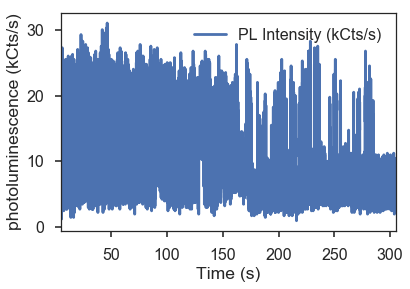

today: 2018-06-13


'O:\\User\\Viva\\analysis\\blinker_analysis\\taken-2018-05-31'

In [81]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 17:17:43 2018

Blinker analysis

@author: Viva Horowitz
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
sns.set(style='ticks')
sns.set_context('poster')

# ** set for each dataset
datadate = '2018-05-31'
datafolder = r'O:\User\Viva\data\2018-05-31_blinking-statistics'
filename = r'04-21-2018.11,00am.FIBedhBN\02.txt'
analysisfolder = r'O:\User\Viva\analysis\blinker_analysis'

os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kCts/s)'
data = pd.read_csv(filename,
                   skiprows=1,
                   header=None,
                   sep='\t',
                   names=['Time (s)','PL Intensity (kCts/s)'],
                   usecols=[0,1])
data = data.set_index(tname)
print(data.head())

data.plot()
plt.ylabel('photoluminescence (kCts/s)')
plt.show()

filename = filename.replace('\\','-')
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
os.getcwd()

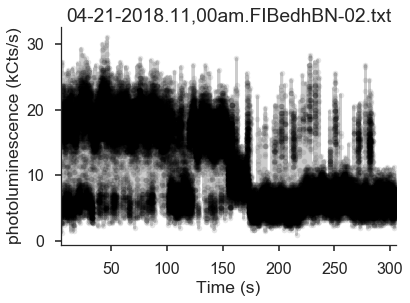

In [2]:
fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)

plt.title(filename)

sns.despine()
plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight', dpi=200)

plt.show()

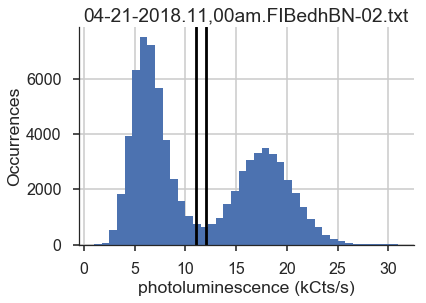

In [6]:
data.hist(bins=40)  # ** adjust bins as needed
plt.xlabel('photoluminescence (kCts/s)')
plt.locator_params(axis='x', nbins=10)
ax = plt.gca()

# ** Need to pick an appropriate threshold between on and off for each dataset
uthreshold = 12
lthreshold = uthreshold-1

ax.axvline(x=uthreshold, color='k')
ax.axvline(x=lthreshold, color = 'k')
#ax.tick_params(axis='x',which='minor',bottom='on')
#ax.xaxis.set_minor_locator(minorLocator)

plt.title(filename)
plt.ylabel('Occurrences')
sns.despine()

plt.savefig(today + ',' + filename+',PLhistogram.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',PLhistogram.png', bbox_inches='tight', dpi=200)

plt.show()

Collection rate: 250.0 Hz
Time bin size: 0.004 sec


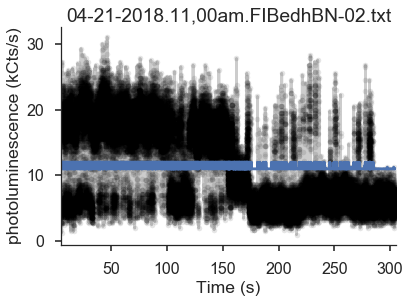

In [7]:
# The data was collected at a particular rate
timesetting = data.index[1]-data.index[0]
fps = 1/timesetting
print('Collection rate: ' + str(fps) + ' Hz')
print('Time bin size: ' + str(timesetting) + ' sec')

# With an uthreshold and an lthreshold
# This code has an in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either. 
# This seems like the most straightforward way to deal with (rare) cases in between.
# Other options are shown.


threshdata = data[PLname].clip(upper=uthreshold, lower=lthreshold)


fig2,axPL = plt.subplots()
data.plot(marker='.',linestyle='None',legend=False, alpha=0.1, ax=axPL, color='k')
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
threshdata.plot(legend=False)
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)
plt.title(filename)
sns.despine()

plt.savefig(today + ',' + filename+',blinkingandthreshold.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinkingandthreshold.png', bbox_inches='tight', dpi=200)

plt.show()

In [8]:
# Main method: in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either.
downtimes2= threshdata[threshdata != uthreshold].index
uptimes2=threshdata[threshdata != lthreshold].index

#print(uptimes2)
#print(downtimes2)

# Alternate option (not used)
uptimes= threshdata[threshdata == uthreshold].index
downtimes=threshdata[threshdata == lthreshold].index

#print(uptimes)
#print(downtimes)

# We can compare the two ways of interpreting blinks.
# There is a discrepancy at about 22 seconds between the two interpretations. 
# It's a matter of whether we consider it stayed off or 
# if we consider that it came up enough to have ended the off blink and began another.
# I tend to think it ended one and began another in this case, so I'm going to use uptimesep2 as my off duration.

# subtracting each time from the last time we had the same state gives the amount of time it was not in that state.
# Therefore the separation between up times is in fact the duration of time off.
uptimesep = uptimes[1:] - uptimes[:-1]
uptimesep2 = uptimes2[1:] - uptimes2[:-1]

"""
plt.plot(uptimes[:-1],uptimesep, '.-')
plt.plot(uptimes2[:-1],uptimesep2, '-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink off (s)')
plt.figure()
data.plot()
plt.show()
"""

# We can compare the two ways of interpreting blinks. It looks like they mostly agree.

downtimesep = downtimes[1:] - downtimes[:-1]
downtimesep2 = downtimes2[1:] - downtimes2[:-1]

"""
plt.plot(downtimes[:-1],downtimesep,'.-')
plt.plot(downtimes2[:-1],downtimesep2,'-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink on (s)')
#plt.figure()
data.plot()
plt.show()
"""

# I chose to use downtimesep2 and uptimesep2, as detailed above.

ontimes = filter(lambda a: a > 1.5*timesetting, downtimesep2)
offtimes = filter(lambda a: a > 1.5*timesetting, uptimesep2)


## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

# http://code.activestate.com/recipes/66472-frange-a-range-function-with-float-increments/
# could also use linspace
def frange(start, end=None, inc=None):
    "A range function, that does accept float increments..."

    if end == None:
        end = start + 0.0
        start = 0.0

    if inc == None:
        inc = 1.0

    L = []
    while 1:
        next = start + len(L) * inc
        if inc > 0 and next >= end:
            break
        elif inc < 0 and next <= end:
            break
        L.append(next)
        
    return L

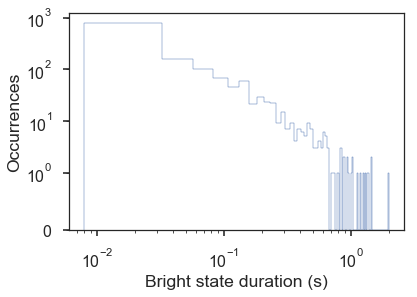

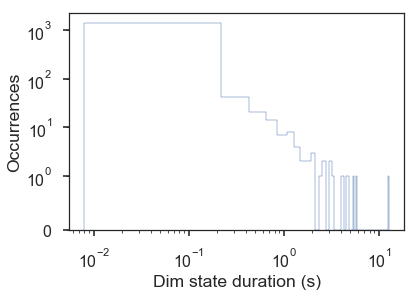

In [78]:
# ** Choose a nice number of bins to see how the data look.
# It's better to have as many bins as possible before the first empty bin.

numonbins = 80
numoffbins = 60

plt.hist(ontimes, bins=numonbins, histtype='step')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
plt.show()
plt.hist(offtimes, bins=numoffbins, histtype='step')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.set_yscale('symlog', linthreshy=1)
ax.set_xscale('log')
plt.show()

In [60]:
## I decided to start my bins at 0. 
# This might be different from the built in hist function.

oninc = max(ontimes)/numonbins
onbins= frange(min(ontimes),max(ontimes)+oninc*3,oninc)
#print(onbins[0:5])


offinc = max(offtimes)/numoffbins

"""
offbins=np.linspace(min(offtimes),max(offtimes),numoffbins+1)
print("linspace option (not used):")
print(offbins)
offbins= frange(min(offtimes),max(offtimes),offinc)
print("frange approach:")
print(offbins)
#print(offbins[0:5])
"""

offbins= frange(min(offtimes),max(offtimes)+offinc*3,offinc)
print("frange approach and pad 3 bins to right (used):")
print(offbins)

centeredonbins = frange(min(ontimes)+oninc/2,max(ontimes)+oninc*3+oninc/2,oninc)
centeredoffbins= frange(min(offtimes)+offinc/2,max(offtimes)+offinc*3+offinc/2,offinc)
#centeredoffbins=np.linspace(offinc/2,max(offtimes)+offinc/2,numoffbins)

"""
print('\n')
print(onbins[-5:])
print(centeredonbins[-5:])


print("Make sure ")
print(len(centeredonbins))
print(len(onbins))
print(len(centeredoffbins))
print(len(offbins))
"""

frange approach and pad 3 bins to right (used):
[0.0079999999999813554, 0.22066666666664786, 0.43333333333331436, 0.64599999999998081, 0.85866666666664737, 1.0713333333333139, 1.2839999999999803, 1.4966666666666468, 1.7093333333333134, 1.9219999999999799, 2.1346666666666465, 2.3473333333333128, 2.5599999999999792, 2.772666666666646, 2.9853333333333123, 3.1979999999999791, 3.4106666666666454, 3.6233333333333118, 3.8359999999999785, 4.0486666666666453, 4.2613333333333117, 4.473999999999978, 4.6866666666666443, 4.8993333333333107, 5.111999999999977, 5.3246666666666442, 5.5373333333333106, 5.7499999999999769, 5.9626666666666432, 6.1753333333333096, 6.3879999999999768, 6.6006666666666431, 6.8133333333333095, 7.0259999999999758, 7.2386666666666422, 7.4513333333333094, 7.6639999999999757, 7.8766666666666421, 8.0893333333333093, 8.3019999999999747, 8.514666666666642, 8.7273333333333074, 8.9399999999999746, 9.1526666666666419, 9.3653333333333073, 9.5779999999999745, 9.79066666666664, 10.0033333

'\nprint(\'\n\')\nprint(onbins[-5:])\nprint(centeredonbins[-5:])\n\n\nprint("Make sure ")\nprint(len(centeredonbins))\nprint(len(onbins))\nprint(len(centeredoffbins))\nprint(len(offbins))\n'

In [61]:
onhist = histc(ontimes, np.asarray(onbins))
offhist = histc(offtimes, np.asarray(offbins))

red data are histogram data and black data are shifted to be centered on the bin


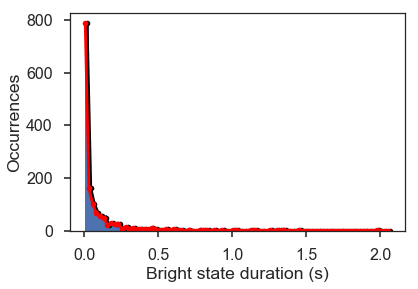

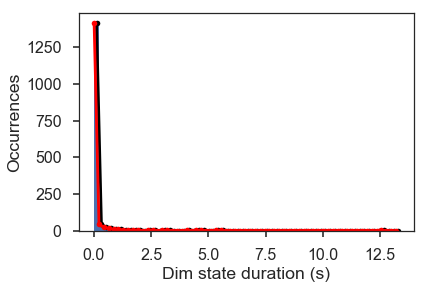

In [62]:
print("red data are histogram data and black data are shifted to be centered on the bin")

#fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False)
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-k')
ax1.plot(onbins,onhist[0],'.-r')
plt.hist(ontimes, bins=numonbins)
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)

# Apparently my digitize and the hist function don't quite give the same output. 
# I think the hist command doesn't start at zero.
# Either way is probably fine.

#plt.yscale('log')
#plt.show()
fig,ax2 = plt.subplots()
ax2.plot(centeredoffbins,offhist[0],'.-k')
ax2.plot(offbins,offhist[0],'.-r')
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax2.set_yscale('symlog', linthreshy=1)
plt.show()

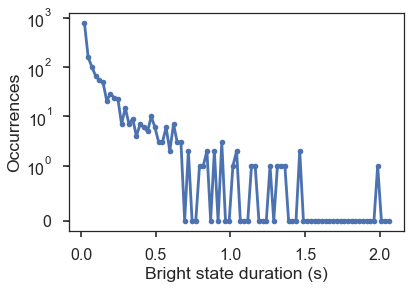

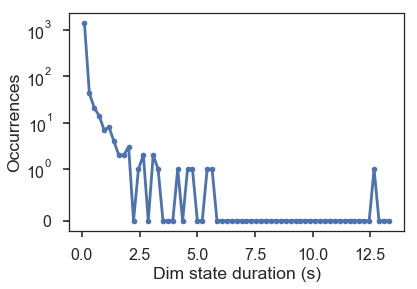

In [63]:
#fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False)
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)

#plt.yscale('log')
#plt.show()
fig,ax2 = plt.subplots()
ax2.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax2.set_yscale('symlog', linthreshy=1)
plt.show()

In [64]:
from scipy.optimize import curve_fit
import scipy
print(scipy.__version__)
# need at least version 14.0 of scipy.

def expfit(t, A, tau):
    return (A * np.exp(t/(-tau)))

def powlaw(t, C, m):
    return C * t**(-m)

# Trying to find good guess
#onparamexp[1]=-.8
#onfitexp = 30 * np.exp(centeredonbins/(onparamexp[1]))

0.17.1


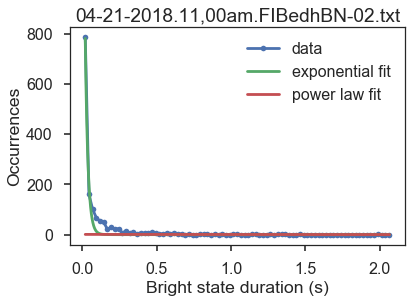

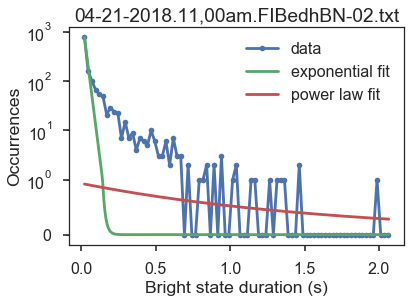

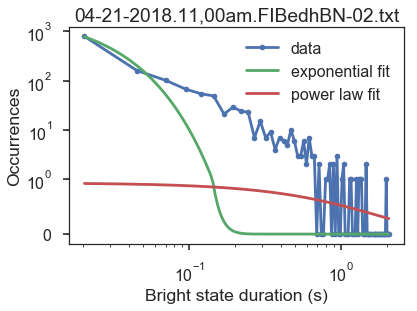

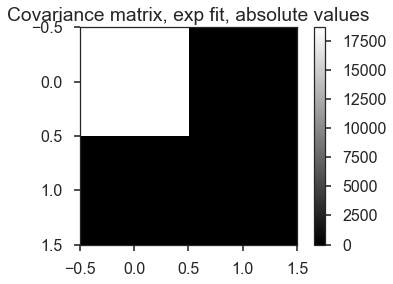

It's ok to use the uncertainties below as long as there aren't strong diagonal values.


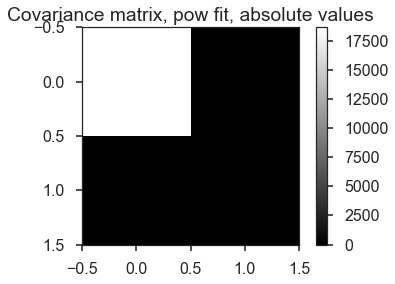

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Exponential fit:
On Coefficient A_up = 2383.33781647 ± 136.581976747
time constant tau_up = 0.0183292724293 ± 0.000828305933436 sec
Power law:
On Coefficient C_up = 0.933914618782 ± 0.0935072810843
logarithmic slope m_up = 1.73019999667 ± 0.0262061026293


In [65]:
# Create lists
onhistl = list(onhist[0])
centeredonbinstrunc = list(centeredonbins) # use the list command to make a copy   
offhistl = list(offhist[0])
centeredoffbinstrunc = list(centeredoffbins) # use the list command to make a copy

onfitx = np.linspace(min(centeredonbins),len(onhistl)*oninc,numonbins*5)

# on time exponential fit, not truncated
onparamexp, onpcovexp = curve_fit(expfit, centeredonbinstrunc, onhistl,p0 = (30, 0.8))
onfitexp = expfit(onfitx,onparamexp[0],onparamexp[1])

# on time power law fit, not truncated
onparampow, onpcovpow = curve_fit(powlaw, centeredonbinstrunc, onhistl,p0 = (.6, 2))
onfitpow = expfit(onfitx,onparampow[0],onparampow[1])


fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-', label='data')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
ax1.plot(onfitx, onfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-', label='data')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
ax1.plot(onfitx, onfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-', label='data')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
ax1.plot(onfitx, onfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
ax1.set_xscale('log')
plt.show()

plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, exp fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, pow fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

print 'Exponential fit:'
print  'On Coefficient A_up = ' + str(onparamexp[0]) + ' ± ' + str(np.sqrt(onpcovexp[0,0]))
print 'time constant tau_up = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'

print 'Power law:'
print  'On Coefficient C_up = ' + str(onparampow[0]) + ' ± ' + str(np.sqrt(onpcovpow[0,0]))
print 'logarithmic slope m_up = ' + str(onparampow[1]) + ' ± ' + str(np.sqrt(onpcovpow[1,1]))


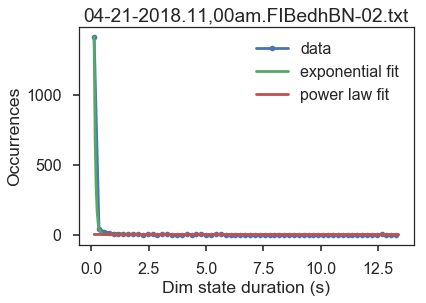

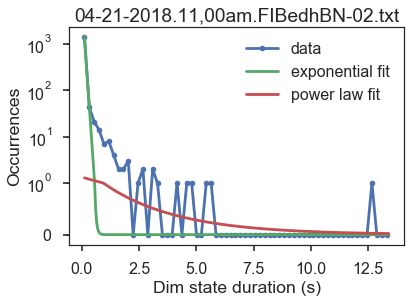

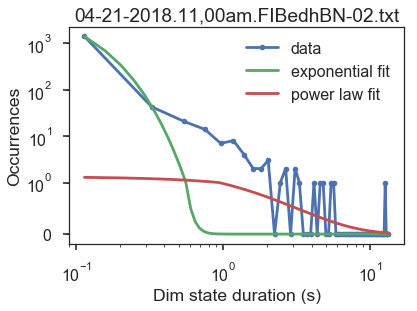

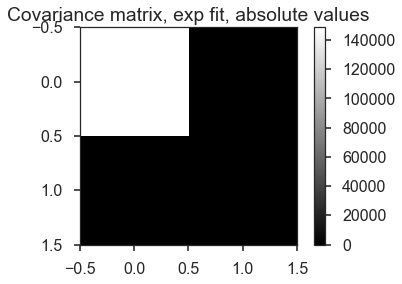

It's ok to use the uncertainties below as long as there aren't strong diagonal values.


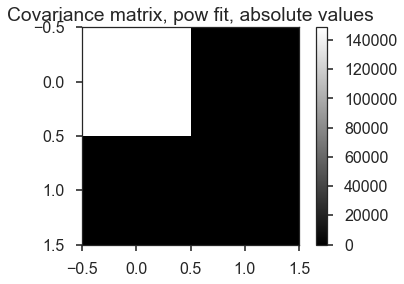

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Exponential fit:
off Coefficient A_dim = 9083.31031229 ± 385.752910002
time constant tau_dim = 0.0614217889029 ± 0.0013963932987 sec
Power law:
off Coefficient C_dim = 1.34035014385 ± 0.138036467305
logarithmic slope m_dim = 3.20928791979 ± 0.0475092354741


In [66]:
showpowfit = True

offfitx = np.linspace(min(centeredoffbins),len(offhistl)*offinc,numoffbins*5)

# off time exponential fit
offparamexp, offpcovexp = curve_fit(expfit, centeredoffbinstrunc, offhistl,p0 = (30, 0.8))
offfitexp = expfit(offfitx,offparamexp[0],offparamexp[1])

# off time power law fit
offparampow, offpcovpow = curve_fit(powlaw, centeredoffbinstrunc, offhistl,p0 = (.6, 2))
offfitpow = expfit(offfitx,offparampow[0],offparampow[1])

# display
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label='exponential fit')
if showpowfit:
    ax1.plot(offfitx, offfitpow, label= 'power law fit')
plt.title(filename)
plt.legend()
ax1.set_yscale('symlog', linthreshy=1)
ax1.set_xscale('log')
plt.show()

plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, exp fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, pow fit, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")

print 'Exponential fit:'
print  'off Coefficient A_dim = ' + str(offparamexp[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau_dim = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Power law:'
print  'off Coefficient C_dim = ' + str(offparampow[0]) + ' ± ' + str(np.sqrt(offpcovpow[0,0]))
print 'logarithmic slope m_dim = ' + str(offparampow[1]) + ' ± ' + str(np.sqrt(offpcovpow[1,1]))


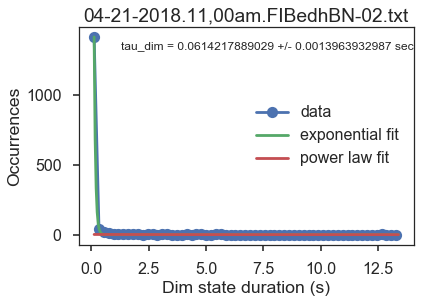

In [67]:
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-', label='data')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label="exponential fit")
if showpowfit:
    ax1.plot(offfitx,offfitpow, label='power law fit')
plt.text(1.0,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename) 
plt.legend(loc=5)

plt.show()

In [68]:
#basefilename = today + ',' + filename+',offblinks' + infostr

def saveeveryfig(fig,ax,basefilename,fitx,powfit):
    sns.despine()
    
    fig.savefig(basefilename + '.pdf', bbox_inches='tight', dpi=200)
    fig.savefig(basefilename + '.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('symlog', linthreshy=1)
    fig.savefig(basefilename + ',semisymlog.pdf', bbox_inches='tight', dpi=200)
    fig.savefig(basefilename + ',semisymlog.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('linear')
    ax.plot(fitx, powfit, label="power law")
    ax.legend(loc=5)
    fig.savefig(basefilename + ',powfit.pdf', bbox_inches='tight', dpi=200)
    fig.savefig(basefilename + ',powfit.png', bbox_inches='tight', dpi=200)

    ax.set_yscale('symlog', linthreshy=1)
    ax.legend(loc=3)
    fig.savefig(basefilename + ',powfit,semisymlog.pdf', bbox_inches='tight', dpi=200)
    fig.savefig(basefilename + ',powfit,semisymlog.png', bbox_inches='tight', dpi=200)

    ax.set_xscale('log')
    fig.savefig(basefilename + ',powfit,symloglog.pdf', bbox_inches='tight', dpi=200)
    fig.savefig(basefilename + ',powfit,symloglog.png', bbox_inches='tight', dpi=200)

dim time constant tau_dim = 0.0614217889029 ± 0.0013963932987 sec
bright time constant tau = 0.0183292724293 ± 0.000828305933436 sec


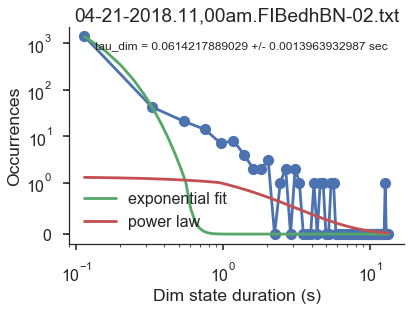

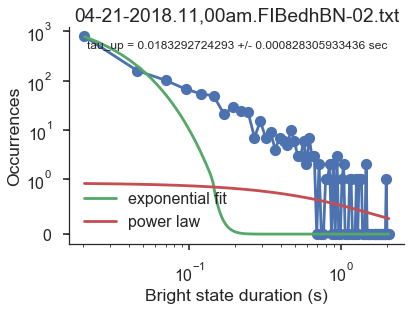

In [69]:
# Save figures

# mpl.rcParams['figure.dpi'] = 200

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ',fitpast0'

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexp, label="exponential fit")
plt.text(0.95,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

saveeveryfig(fig,ax1,today + ',' + filename+',offblinks' + infostr,offfitx,offfitpow)

print 'dim time constant tau_dim = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'


# On blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'o-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfitexp, label='exponential fit')
plt.text(0.95,0.9,'tau_up = '  + str(onparamexp[1]) + ' +/- '  + str(np.sqrt(onpcovexp[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

saveeveryfig(fig,ax1,today + ',' + filename+',onblinks' + infostr,onfitx,onfitpow)

print 'bright time constant tau = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'


plt.show()


In [70]:
#mpl.rcParams.update(mpl.rcParamsDefault)
#sns.set(style='ticks')
#sns.set_context('poster')

In [71]:
# reset in case I've already run this.
onhistl = list(onhist[0])
centeredonbinstrunc = list(centeredonbins) # use the list command to make a copy
offhistl = list(offhist[0])
centeredoffbinstrunc = list(centeredoffbins) # use the list command to make a copy

# cut off data above zero bin
zeroindexon = onhistl.index(0)
del onhistl[zeroindexon:]
del centeredonbinstrunc[zeroindexon:]
zeroindexoff = offhistl.index(0)
del offhistl[zeroindexoff:]
del centeredoffbinstrunc[zeroindexoff:]
    
infostr = ''

try:
    guessonparamexp = onparamexp
except:
    guessonparamexp=(30,0.8)
print('Guessing: ' + str(guessonparamexp))    
    
try:
    guessoffparamexp = offparamexp
except:
    guessoffparamexp = (30,0.8)
print('Guessing: ' + str(guessoffparamexp))

try:
    guessonparampow = onparampow
except:
    guessonparampow = (30,1)
print('Guessing: ' + str(guessonparampow))

try:
    guessoffparampow = offparampow
except:
    guessoffparampow = (30,1)
print('Guessing: ' + str(guessoffparampow))

Guessing: [  2.38333782e+03   1.83292724e-02]
Guessing: [  9.08331031e+03   6.14217889e-02]
Guessing: [ 0.93391462  1.7302    ]
Guessing: [ 1.34035014  3.20928792]


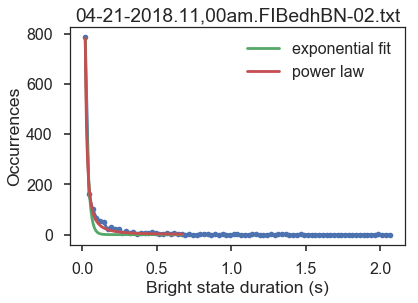

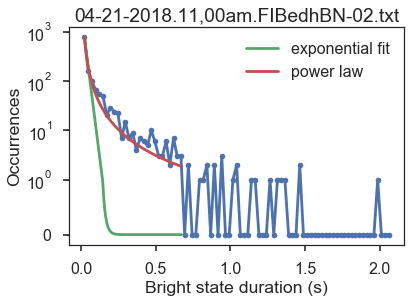

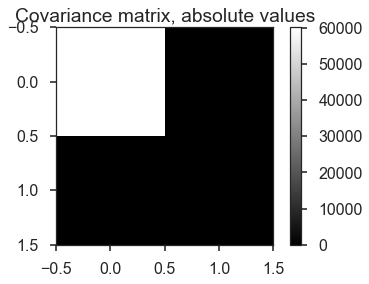

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 2383.35012639 ± 245.539926008
time constant tau_up = 0.0183291943149 ± 0.00148901315733 sec


In [72]:
# on time fit, truncated

onfitxtrunc = np.linspace(min(centeredonbins),len(onhistl)*oninc,numonbins*5)

# exponential fit
onparamexptrunc, onpcovexp = curve_fit(expfit, centeredonbinstrunc, onhistl,p0 = guessonparamexp)
onfitexptrunc = expfit(onfitxtrunc,onparamexptrunc[0],onparamexptrunc[1])

# power law fit
onparampowtrunc, onpcovpow = curve_fit(powlaw, centeredonbinstrunc, onhistl,p0 = guessonparampow)
onfitpowtrunc = powlaw(onfitxtrunc,onparampowtrunc[0],onparampowtrunc[1])

# display the fit
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitxtrunc,onfitexptrunc, label="exponential fit")
if showpowfit:
    ax1.plot(onfitxtrunc, onfitpowtrunc, label="power law")
    plt.legend()
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog',linthreshy=1)
ax1.plot(onfitxtrunc,onfitexptrunc, label="exponential fit")
if showpowfit:
    ax1.plot(onfitxtrunc, onfitpowtrunc, label="power law")
    plt.legend()
plt.title(filename)
plt.show()

plt.imshow(abs(onpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(onparamexptrunc[0]) + ' ± ' + str(np.sqrt(onpcovexp[0,0]))
print 'time constant tau_up = ' + str(onparamexptrunc[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'



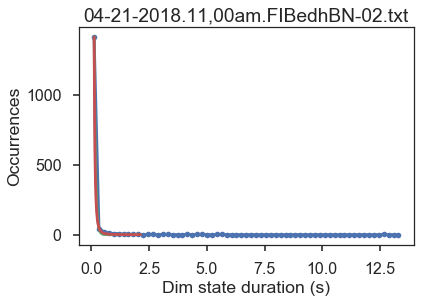

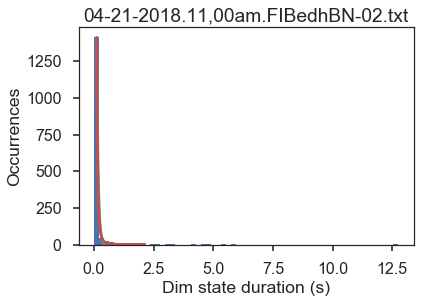

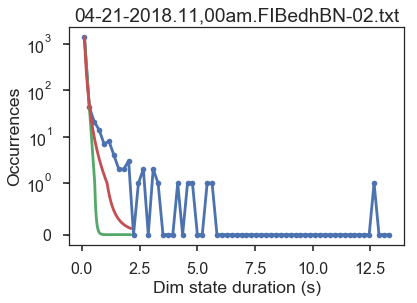

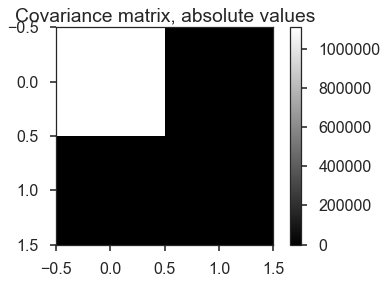

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 9083.31060307 ± 1053.66681108
time constant tau = 0.0614217878486 ± 0.00381417738833 sec
Exponential fit, truncated:
off Coefficient A_dim = 9083.31060307 ± 1053.66681108
time constant tau_dim = 0.0614217878486 ± 0.00381417738833 sec
Power law fit, truncated:
off Coefficient C_dim = 1.33925568345 ± 0.373558574471
logarithmic slope m_dim = 3.20966475721 ± 0.128672208094


In [73]:
# off time fit, truncated

offfitx = np.linspace(min(centeredoffbins),len(offhistl)*offinc,numoffbins*5)

# exponential fit
offparamexptrunc, offpcovexp = curve_fit(expfit, centeredoffbinstrunc, offhistl,p0 = guessoffparamexp)
offfitexptrunc = expfit(offfitx,offparamexptrunc[0],offparamexptrunc[1])

# power law fit
offparampowtrunc, offpcovpow = curve_fit(powlaw, centeredoffbinstrunc, offhistl,p0 = guessoffparampow)
offfitpowtrunc = powlaw(offfitx,offparampowtrunc[0],offparampowtrunc[1])

# display the fit
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfitexptrunc, label="exponential")
if showpowfit:
    ax1.plot(offfitx, offfitpowtrunc, label="power law")
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfitexptrunc, label="exponential")
if showpowfit:
    ax1.plot(offfitx, offfitpowtrunc, label="power law")
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfitexptrunc, label="exponential")
if showpowfit:
    ax1.plot(offfitx, offfitpowtrunc, label="power law")
plt.title(filename)
plt.show()

plt.imshow(abs(offpcovexp), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(offparamexptrunc[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau = ' + str(offparamexptrunc[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Exponential fit, truncated:'
print  'off Coefficient A_dim = ' + str(offparamexptrunc[0]) + ' ± ' + str(np.sqrt(offpcovexp[0,0]))
print 'time constant tau_dim = ' + str(offparamexptrunc[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'

print 'Power law fit, truncated:'
print  'off Coefficient C_dim = ' + str(offparampowtrunc[0]) + ' ± ' + str(np.sqrt(offpcovpow[0,0]))
print 'logarithmic slope m_dim = ' + str(offparampowtrunc[1]) + ' ± ' + str(np.sqrt(offpcovpow[1,1]))

dim time constant tau = 0.0614217889029 ± 0.00381417738833 sec
m_dim = 3.20966475721 +/- 0.128672208094
bright time constant tau_up = 0.0183292724293 ± 0.00148901315733 sec
m_up = 1.73019999667 ± 0.0470912491822


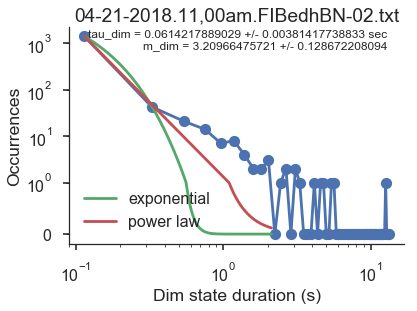

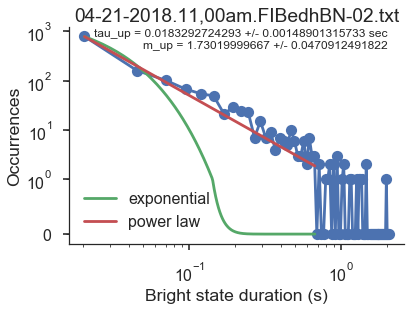

In [74]:
# Save figures, truncated fits

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ''

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Dim state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfitexptrunc, label="exponential")
plt.text(0.95,0.9,'tau_dim = '  + str(offparamexp[1]) + ' +/- '  + str(np.sqrt(offpcovexp[1,1])) 
         + ' sec\nm_dim = ' + str(offparampowtrunc[1]) + ' +/- ' + str(np.sqrt(offpcovpow[1,1])),
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

saveeveryfig(fig,ax1,today + ',' + filename+',offblinks' + infostr,offfitx,offfitpowtrunc)


print 'dim time constant tau = ' + str(offparamexp[1]) + ' ± ' + str(np.sqrt(offpcovexp[1,1])) + ' sec'
print('m_dim = ' + str(offparampowtrunc[1]) + ' +/- ' + str(np.sqrt(offpcovpow[1,1])))

# On blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'o-')
plt.xlabel('Bright state duration (s)')
plt.ylabel('Occurrences')
ax1.plot(onfitxtrunc,onfitexptrunc, label="exponential")
plt.text(0.95,0.9,'tau_up = '  + str(onparamexp[1]) + ' +/- '  + str(np.sqrt(onpcovexp[1,1])) + ' sec\n'
         +'m_up = ' + str(onparampow[1]) + ' +/- ' + str(np.sqrt(onpcovpow[1,1])),
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

saveeveryfig(fig,ax1,today + ',' + filename+',onblinks' + infostr,onfitxtrunc,onfitpowtrunc)

print 'bright time constant tau_up = ' + str(onparamexp[1]) + ' ± ' + str(np.sqrt(onpcovexp[1,1])) + ' sec'
print 'm_up = ' + str(onparampow[1]) + ' ± ' + str(np.sqrt(onpcovpow[1,1])) 


plt.show()

In [75]:
print 'Exp [A, tau]'
print offparamexp
print onparamexp

print 'Pow [C, m]'
print offparampow
print onparampow

print '\n'

print 'With truncation (ignore first empty bin and all following bins)'
print 'Exp [A, tau]'
print offparamexptrunc
print onparamexptrunc

print 'Pow [C, m]'
print offparampowtrunc
print onparampowtrunc

Exp [A, tau]
[  9.08331031e+03   6.14217889e-02]
[  2.38333782e+03   1.83292724e-02]
Pow [C, m]
[ 1.34035014  3.20928792]
[ 0.93391462  1.7302    ]


With truncation (ignore first empty bin and all following bins)
Exp [A, tau]
[  9.08331060e+03   6.14217878e-02]
[  2.38335013e+03   1.83291943e-02]
Pow [C, m]
[ 1.33925568  3.20966476]
[ 0.9374252   1.72922029]
